In [1]:
# pip install catboost==1.1.1

In [2]:
# pip install --upgrade pip

In [3]:
from catboost import CatBoostRegressor
from functools import partial
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

/usr/local/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Preprocessing

In [4]:
df = pd.read_excel('kaggle_data.xlsx', sheet_name='Dataset')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=False)

In [6]:
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Price - FTSE 250,Price - FTSE 100,Price - GBP - USD,Price - XLF (financial sector index),Price - EWU,Change % - volatility index,gold price
0,2012-12-31,240.245998,243.572501,240.015032,242.463661,176.294033,8654190.0,7958.42,5897.81,1.6253,13.31,35.88,-0.2069,1357.398
1,2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,8115.70,6027.37,1.6256,13.69,36.42,NaN,1367.928
2,2013-01-03,252.449969,256.346271,250.777993,253.690802,184.457215,30478242.0,8141.06,6047.34,1.6107,13.68,36.10,-0.0082,1356.426


In [7]:
replacing_col = ['Price - FTSE 250', 'Price - FTSE 100', 'Price - GBP - USD',
                 'Price - XLF (financial sector index)', 'Price - EWU', 'gold price']

df[replacing_col] = df[replacing_col].replace(0, np.nan)

In [8]:
for col in replacing_col:
    df[col].fillna((df[col].shift() + df[col].shift(-1)) / 2, inplace=True)

In [9]:
# mask = df.notna().all(axis=1)
mask = df['Close'].notna()

train = df[mask]
test = df[~mask]

In [10]:
test_dates = list(test['Date'])

In [11]:
train.shape

(2015, 14)

In [12]:
test.shape

(513, 14)

In [13]:
train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Price - FTSE 250', 'Price - FTSE 100', 'Price - GBP - USD',
       'Price - XLF (financial sector index)', 'Price - EWU',
       'Change % - volatility index', 'gold price'],
      dtype='object')

In [14]:
train

,Date,Open,High,Low,Close,Adj Close,Volume,Price - FTSE 250,Price - FTSE 100,Price - GBP - USD,Price - XLF (financial sector index),Price - EWU,Change % - volatility index,gold price
0,2012-12-31,240.245998,243.572501,240.015032,242.463661,176.294033,8654190.0,7958.42,5897.81,1.6253,13.31,35.88,-0.2069,1357.398
2,2013-01-03,252.449969,256.346271,250.777993,253.690802,184.457215,30478242.0,8141.06,6047.34,1.6107,13.68,36.10,-0.0082,1356.426
3,2013-01-04,254.449875,257.603359,252.924079,255.883361,186.051448,33910280.0,8169.14,6089.84,1.6071,13.85,36.36,-0.0501,1335.609
4,2013-01-07,258.571368,265.438675,254.007233,264.276487,192.154031,65847776.0,8186.58,6064.58,1.6114,13.81,36.28,-0.0029,1333.503
5,2013-01-08,262.718756,271.802636,259.867109,264.190576,192.091565,53214119.0,8130.60,6053.63,1.6056,13.77,36.12,-0.0123,1346.382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2523,2022-12-22,158.636371,159.560617,157.693059,157.693059,150.353996,18924838.0,15625.39,7469.28,1.2043,33.76,30.62,0.0947,1454.193
2524,2022-12-23,157.486608,158.709301,156.985506,158.087938,150.730498,6151381.0,15682.03,7473.01,1.2058,33.95,30.81,-0.0501,1461.402
2525,2022-12-28,158.575710,159.998722,157.774010,159.217068,151.807079,16008792.0,15728.18,7497.19,1.2013,33.82,30.55,0.0226,1470.798
2526,2022-12-29,158.429591,159.631785,157.327571,159.631785,152.202481,17344031.0,15823.54,7512.72,1.2052,34.29,30.81,-0.0316,1479.060


## Feature Engineering

In [15]:
def date_to_integer(date_string):
    # Split the date string into year, month, and day components.
    date_string = date_string.strftime("%Y-%m-%d")
    year, month, day = date_string.split("-")

    # Multiply the year by 366, the month by 31, and the day by 1.
    year_days = int(year) * 366
    month_days = int(month) * 31
    day_days = int(day)

    # Add the three values together.
    date_integer = year_days + month_days + day_days

    return date_integer

train["Date"] = train["Date"].apply(date_to_integer)
test["Date"] = test["Date"].apply(date_to_integer)

/var/folders/js/m5qnfp1x15x0yvglhtdhp_cm0000gn/T/ipykernel_51384/2655470369.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Date"] = train["Date"].apply(date_to_integer)
/var/folders/js/m5qnfp1x15x0yvglhtdhp_cm0000gn/T/ipykernel_51384/2655470369.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Date"] = test["Date"].apply(date_to_integer)


In [16]:
colnames = ["Date", "Price - FTSE 250", 'Price - FTSE 100', 'Price - GBP - USD', 'Price - XLF (financial sector index)', 'Price - EWU',  'gold price']
# ('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])),
pca_md = Pipeline([ 
                   ('stand', StandardScaler()), 
                   ('pca', PCA())]).fit(train[colnames])

pca_md

Pipeline(steps=[('stand', StandardScaler()), ('pca', PCA())])

In [17]:
len(np.cumsum(pca_md['pca'].explained_variance_ratio_))

7

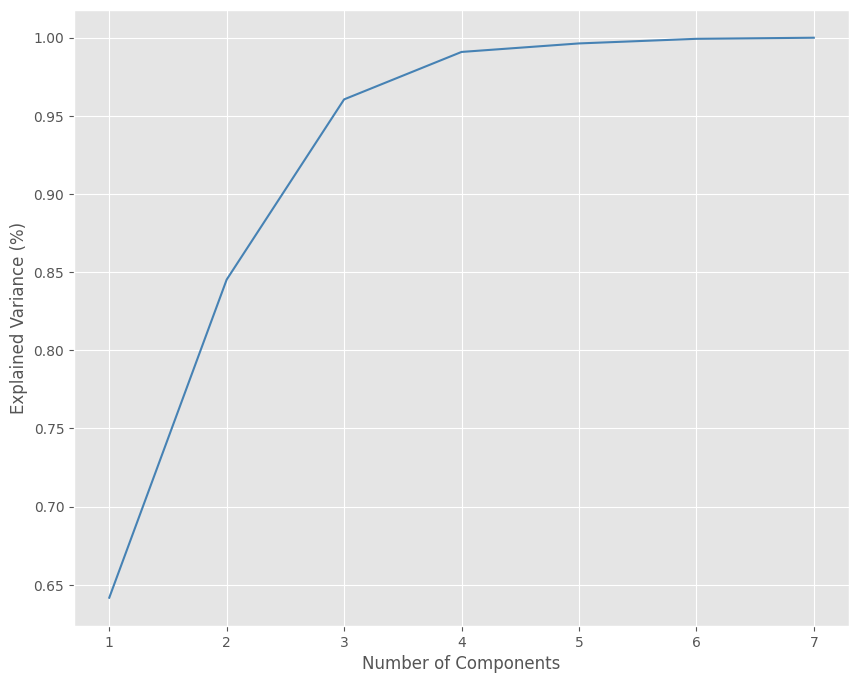

In [18]:
plt.figure(figsize = (10, 8))
ax = sns.lineplot(x = [i for i in range(1, 8)], y = np.cumsum(pca_md['pca'].explained_variance_ratio_), color = 'steelblue', markers = True);
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance (%)')
ax.set_xticks([i for i in range(1, 8)]);

In [19]:
# ('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])),
pca_10 = Pipeline([ 
                   ('stand', StandardScaler()), 
                   ('pca', PCA(n_components = 5))]).fit_transform(train[colnames])

pca_10 = pd.DataFrame(pca_10, columns = [str('PCA_') + str(i) for i in range(1, 6)])
pca_10['Close'] = train['Close']

sns.pairplot(data = pca_10, hue = 'Close', corner = True);

In [20]:
pca_10

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,Close
0,-3.341174,1.711739,-1.561048,-0.929142,-0.151849,242.463661
1,-3.203168,1.468170,-1.454857,-1.049450,-0.180991,NaN
2,-3.211770,1.347273,-1.379019,-1.028949,-0.153907,253.690802
3,-3.229938,1.384900,-1.395937,-0.987021,-0.158112,255.883361
4,-3.197884,1.449480,-1.404080,-1.036120,-0.162792,264.276487
...,...,...,...,...,...,...
2010,3.176963,-0.181130,-0.090463,-0.715920,0.546103,146.406566
2011,3.193334,-0.217157,-0.140166,-0.723466,0.540983,142.511984
2012,3.251944,-0.196691,-0.116128,-0.772530,0.507589,136.413105
2013,3.287380,-0.272716,-0.187909,-0.770831,0.506568,143.004698


  0%|          | 0/19 [00:00<?, ?it/s]

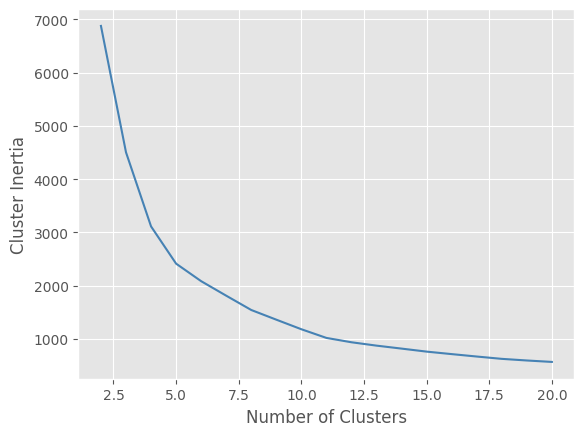

In [21]:
inertias = list()

for i in tqdm(range(2, 21)):
# ('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
    kmeans_md = Pipeline([
                          ('stand', StandardScaler()), 
                          ('kmeans', KMeans(n_clusters = i, n_init = 20, random_state = 42))]).fit(train[colnames])

    inertias.append(kmeans_md['kmeans'].inertia_)
    
sns.lineplot(x = [i for i in range(2, 21)], y = inertias, color = 'steelblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Inertia');

In [22]:
# ('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
kmeans = Pipeline([
                   ('stand', StandardScaler()), 
                   ('kmeans', KMeans(n_clusters = 7, n_init = 20, random_state = 42))]).fit(train[colnames])

train['cluster'] = kmeans['kmeans'].labels_

print('The proportion of Close in each of the clusters is \n')
print(train.groupby('cluster')['Close'].mean())

The proportion of Close in each of the clusters is 

cluster
0    250.607901
1    172.485508
2    187.927837
3    182.299112
4    276.492934
5    206.012349
6    115.349416
Name: Close, dtype: float64


/var/folders/js/m5qnfp1x15x0yvglhtdhp_cm0000gn/T/ipykernel_51384/3841848490.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cluster'] = kmeans['kmeans'].labels_


In [23]:
train.drop(columns = ['Close'], axis = 1).nunique()

Date                                    1996
Open                                    2015
High                                    2015
Low                                     2015
Adj Close                               2015
Volume                                  2014
Price - FTSE 250                        2014
Price - FTSE 100                        2006
Price - GBP - USD                       1591
Price - XLF (financial sector index)    1268
Price - EWU                             1012
Change % - volatility index             1335
gold price                              1689
cluster                                    7
dtype: int64

## Algorithm

In [24]:
X = train[colnames]
Y = train['Close']

test_cv = test[colnames]

In [25]:
def hill_climbing(x, y, x_test):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = mean_squared_error(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1])}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [mean_squared_error(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = mean_squared_error(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = mean_squared_error(y, potential_ensemble)
                # Seek for min in RMSE
                if cv_score < potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds
    
    return [hill_ens_pred_1, hill_ens_pred_2]

In [26]:
ens_cv_scores, ens_preds = list(), list()
hill_ens_cv_scores, hill_ens_preds =  list(), list()

# sk = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 42)
sk = KFold(n_splits=10,random_state=42, shuffle=True)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
    ########
    ## RF ##
    ########

    RF_md = RandomForestRegressor(n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)
    
    RF_pred = RF_md.predict(X_test)
    RF_score = mean_squared_error(Y_test, RF_pred)

    print('Fold', i, '==> RF oof ROC-AUC score is ==>', RF_score)

    RF_pred_test = RF_md.predict(test_cv)
    
    #################
    ## Extra Trees ##
    #################

    ET_md = ExtraTreesRegressor(n_estimators = 500, 
                                 max_depth = 7,
                                 min_samples_split = 15,
                                 min_samples_leaf = 10).fit(X_train, Y_train)

    ET_pred = ET_md.predict(X_test)
    ET_score = mean_squared_error(Y_test, ET_pred)

    print('Fold', i, '==> ET oof ROC-AUC score is ==>', ET_score)

    ET_pred_test = ET_md.predict(test_cv)

    ##########################
    ## HistGradientBoosting ##
    ##########################

    hist_md = HistGradientBoostingRegressor(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 500,
                                             max_depth = 5,
                                             max_bins = 255,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 10).fit(X_train, Y_train)
    
    hist_pred = hist_md.predict(X_test)
    hist_score = mean_squared_error(Y_test, hist_pred)

    print('Fold', i, '==> Hist oof ROC-AUC score is ==>', hist_score)  

    hist_pred_test = hist_md.predict(test_cv)

    ##########
    ## LGBM ##
    ##########
    import lightgbm as lgb
    lgb_train = lgb.Dataset(
        X_train,
        Y_train
    )

    lgb_eval = lgb.Dataset(
        X_test,
        Y_test,
        reference=lgb_train
    )
    
    lgb_param =     {'task': 'train', 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt',
                     'num_iterations': 300000, 'max_depth': -1, 'feature_pre_filter': False, 'lambda_l1': 1.6314697848556082e-05,
                     'lambda_l2': 9.531962710059137e-05, 'num_leaves': 456, 'feature_fraction': 1.0, 'bagging_fraction': 0.9991169270666491,
                     'bagging_freq': 6, 'min_child_samples': 50, 'verbosity': -1, 'learning_rate': 0.007302687871816182,
                     'subsample': 0.9577324834668492, 'colsample_bytree': 0.6442357623063831, 'min_data_in_leaf': 13}
    LGBM_md = lgb.train(
        lgb_param,
        valid_names=['train', 'valid'], 
        valid_sets=[lgb_train, lgb_eval], 
        train_set=lgb_train,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, ),
        ]
    )
    # LGBM_md = LGBMRegressor(objective = 'regression',
    #                          n_estimators = 500,
    #                          max_depth = 7,
    #                          learning_rate = 0.01,
    #                          num_leaves = 20,
    #                          reg_alpha = 3,
    #                          reg_lambda = 3,
    #                          subsample = 0.7,
    #                          colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict(X_test)
    lgb_score = mean_squared_error(Y_test, lgb_pred)

    print('Fold', i, '==> LGBM oof ROC-AUC score is ==>', lgb_score) 

    lgb_pred_test = LGBM_md.predict(test_cv)

    #########
    ## XGB ##
    #########

    params = {             "colsample_bytree" : 0.9868849580322031, 
                           "gamma" : 0.06331177133689585, 
                           "learning_rate": 0.010525081178658337, 
                           "max_depth" : 84, 
                          "min_child_weight" : 5, 
                           "n_estimators" : 681, 
                           "subsample" : 0.4334497862738626}

    XGB_md = XGBRegressor(objective = 'reg:squarederror',
                           tree_method = 'hist',**params).fit(X_train, Y_train)
    
    xgb_pred = XGB_md.predict(X_test)
    xgb_score = mean_squared_error(Y_test, xgb_pred)

    print('Fold', i, '==> XGB oof ROC-AUC score is ==>', xgb_score)

    xgb_pred_test = XGB_md.predict(test_cv)

    ##############
    ## CatBoost ##
    ##############

    Cat_md = CatBoostRegressor(loss_function = 'RMSE',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict(X_test)
    cat_score = mean_squared_error(Y_test, cat_pred)

    print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)

    cat_pred_test = Cat_md.predict(test_cv) 
    
    ##############
    ## Ensemble ##
    ##############
    
    ens_pred_1 = (RF_pred + ET_pred + hist_pred + lgb_pred + xgb_pred + cat_pred) / 6
    ens_pred_2 = (RF_pred_test + ET_pred_test + hist_pred_test + lgb_pred_test + xgb_pred_test + cat_pred_test) / 6
    
    ens_score_fold = mean_squared_error(Y_test, ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)
    
    ############################
    ## Hill Climbing Ensemble ##
    ############################
    
    x = pd.DataFrame({'RF': RF_pred,
                      'ET': ET_pred, 
                      'Hist': hist_pred, 
                      'LGBM': lgb_pred,
                      'XGB': xgb_pred,
                      'Cat': cat_pred})
    y = Y_test
        
    x_test = pd.DataFrame({'RF': RF_pred_test,
                           'ET': ET_pred_test, 
                           'Hist': hist_pred_test, 
                           'LGBM': lgb_pred_test,
                           'XGB': xgb_pred_test,
                           'Cat': cat_pred_test})
    
    hill_results = hill_climbing(x, y, x_test)
    
    hill_ens_score_fold = mean_squared_error(y, hill_results[0])
    # hill_ens_score_fold = ((y-hill_results[0]).abs() / y).mean()
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

----------------------------------------------------------
Fold 0 ==> RF oof ROC-AUC score is ==> 32.80111793944564
Fold 0 ==> ET oof ROC-AUC score is ==> 45.98695003265156
Fold 0 ==> Hist oof ROC-AUC score is ==> 38.010266217595586
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[566]	train's rmse: 3.76779	valid's rmse: 4.67695
Fold 0 ==> LGBM oof ROC-AUC score is ==> 21.873877435959876
Fold 0 ==> XGB oof ROC-AUC score is ==> 18.808596005887964
Fold 0 ==> CatBoost oof ROC-AUC score is ==> 58.01546800961899
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 26.822534046834893
Fold 0 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 17.758175139704942
----------------------------------------------------------
Fold 1 ==> RF oof ROC-AUC score is ==> 35.81260092487543
Fold 1 ==> ET oof ROC-AUC score is ==> 48.12991185231412
Fold 1 ==> Hist oof ROC-AUC score is ==> 43.9734954089653
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[2085]	train's rmse: 2.1821	valid's rmse: 3.87304
Fold 1 ==> LGBM oof ROC-AUC score is ==> 15.000460647850694
Fold 1 ==> XGB oof ROC-AUC score is ==> 16.598864646584925
Fold 1 ==> CatBoost oof ROC-AUC score is ==> 59.08345739486396
Fold 1 ==> Average Ensemble oof ROC-AUC score is ==> 26.84206970670523
Fold 1 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 13.640252288745202
----------------------------------------------------------
Fold 2 ==> RF oof ROC-AUC score is ==> 36.56205066800554
Fold 2 ==> ET oof ROC-AUC score is ==> 57.74014744886793
Fold 2 ==> Hist oof ROC-AUC score is ==> 42.21078960690007
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[730]	train's rmse: 3.49893	valid's rmse: 5.11167
Fold 2 ==> LGBM oof ROC-AUC score is ==> 26.129210247536033
Fold 2 ==> XGB oof ROC-AUC score is ==> 17.266199883408596
Fold 2 ==> CatBoost oof ROC-AUC score is ==> 59.394657021332165
Fold 2 ==> Average Ensemble oof ROC-AUC score is ==> 28.47165997213474
Fold 2 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 16.674636382459045
----------------------------------------------------------
Fold 3 ==> RF oof ROC-AUC score is ==> 29.7825376743219
Fold 3 ==> ET oof ROC-AUC score is ==> 43.9891289301988
Fold 3 ==> Hist oof ROC-AUC score is ==> 44.0145240993605
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[975]	train's rmse: 3.21925	valid's rmse: 4.49887
Fold 3 ==> LGBM oof ROC-AUC score is ==> 20.239866183099842
Fold 3 ==> XGB oof ROC-AUC score is ==> 20.633043371205314
Fold 3 ==> CatBoost oof ROC-AUC score is ==> 55.19987414773805
Fold 3 ==> Average Ensemble oof ROC-AUC score is ==> 24.749856574862072
Fold 3 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 17.18582961570825
----------------------------------------------------------
Fold 4 ==> RF oof ROC-AUC score is ==> 41.59641374351893
Fold 4 ==> ET oof ROC-AUC score is ==> 58.816197594526415
Fold 4 ==> Hist oof ROC-AUC score is ==> 46.1473493083805
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[924]	train's rmse: 3.2526	valid's rmse: 4.57
Fold 4 ==> LGBM oof ROC-AUC score is ==> 20.884945715833076
Fold 4 ==> XGB oof ROC-AUC score is ==> 18.701689416582614
Fold 4 ==> CatBoost oof ROC-AUC score is ==> 69.85762128544451
Fold 4 ==> Average Ensemble oof ROC-AUC score is ==> 31.66492537528064
Fold 4 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 17.520955320964607
----------------------------------------------------------
Fold 5 ==> RF oof ROC-AUC score is ==> 173.01374560379773
Fold 5 ==> ET oof ROC-AUC score is ==> 198.28326605240738
Fold 5 ==> Hist oof ROC-AUC score is ==> 176.60746514199533
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[5262]	train's rmse: 0.346748	valid's rmse: 11.4925
Fold 5 ==> LGBM oof ROC-AUC score is ==> 132.0778570252263
Fold 5 ==> XGB oof ROC-AUC score is ==> 139.8568077727122
Fold 5 ==> CatBoost oof ROC-AUC score is ==> 203.29083527338904
Fold 5 ==> Average Ensemble oof ROC-AUC score is ==> 158.81606308455866
Fold 5 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 129.34142135809614
----------------------------------------------------------
Fold 6 ==> RF oof ROC-AUC score is ==> 36.66592673367465
Fold 6 ==> ET oof ROC-AUC score is ==> 52.54807824417687
Fold 6 ==> Hist oof ROC-AUC score is ==> 40.50597872268181
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1140]	train's rmse: 2.95367	valid's rmse: 3.93685
Fold 6 ==> LGBM oof ROC-AUC score is ==> 15.498814928034946
Fold 6 ==> XGB oof ROC-AUC score is ==> 15.722032151506227
Fold 6 ==> CatBoost oof ROC-AUC score is ==> 53.11469164669009
Fold 6 ==> Average Ensemble oof ROC-AUC score is ==> 26.44608507858609
Fold 6 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 13.906373461311665
----------------------------------------------------------
Fold 7 ==> RF oof ROC-AUC score is ==> 34.04933384846038
Fold 7 ==> ET oof ROC-AUC score is ==> 53.84836967197077
Fold 7 ==> Hist oof ROC-AUC score is ==> 41.02868275863763
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1551]	train's rmse: 2.54389	valid's rmse: 3.83449
Fold 7 ==> LGBM oof ROC-AUC score is ==> 14.703340140046619
Fold 7 ==> XGB oof ROC-AUC score is ==> 13.724878681350928
Fold 7 ==> CatBoost oof ROC-AUC score is ==> 59.638179894883535
Fold 7 ==> Average Ensemble oof ROC-AUC score is ==> 25.328178305147695
Fold 7 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 12.807425431012708
----------------------------------------------------------
Fold 8 ==> RF oof ROC-AUC score is ==> 41.022770442401246
Fold 8 ==> ET oof ROC-AUC score is ==> 56.2203632457111
Fold 8 ==> Hist oof ROC-AUC score is ==> 43.56542724051644
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1486]	train's rmse: 2.58173	valid's rmse: 4.14705
Fold 8 ==> LGBM oof ROC-AUC score is ==> 17.19803865211492
Fold 8 ==> XGB oof ROC-AUC score is ==> 16.289621103818497
Fold 8 ==> CatBoost oof ROC-AUC score is ==> 62.298714613642936
Fold 8 ==> Average Ensemble oof ROC-AUC score is ==> 28.616189908655247
Fold 8 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 14.498063997361001
----------------------------------------------------------
Fold 9 ==> RF oof ROC-AUC score is ==> 32.1632487398934
Fold 9 ==> ET oof ROC-AUC score is ==> 51.86806994537679
Fold 9 ==> Hist oof ROC-AUC score is ==> 41.237817758177876
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1717]	train's rmse: 2.49971	valid's rmse: 3.3535
Fold 9 ==> LGBM oof ROC-AUC score is ==> 11.245929563488732
Fold 9 ==> XGB oof ROC-AUC score is ==> 13.340824207666687
Fold 9 ==> CatBoost oof ROC-AUC score is ==> 57.79121052464827
Fold 9 ==> Average Ensemble oof ROC-AUC score is ==> 25.102387932635953
Fold 9 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 10.27764952519735


In [27]:
print('The average ensemble oof ROC-AUC score over the 10-folds is', np.mean(ens_cv_scores))
print('The hill climbing ensemble oof ROC-AUC score over the 10-folds is', np.mean(hill_ens_cv_scores))

The average ensemble oof ROC-AUC score over the 10-folds is 40.285994998540126
The hill climbing ensemble oof ROC-AUC score over the 10-folds is 26.361078252056096


In [28]:
hill_ens_cv_scores

[17.758175139704942,
 13.640252288745202,
 16.674636382459045,
 17.18582961570825,
 17.520955320964607,
 129.34142135809614,
 13.906373461311665,
 12.807425431012708,
 14.498063997361001,
 10.27764952519735]

## Hyperparameter Tuning

In [29]:
def obj(trial, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=42
    )
    # trial.suggest_int('max_depth', 5, 100)
    # trial.suggest_float('max_depth', .5, 1.)
    # trial.suggest_float('learning_rate', 1e-3, .1, log=True)
    reg = RandomForestRegressor(n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)

    pred = reg.predict(X_test)
    score = mean_squared_error(Y_test, pred)
    return score

In [30]:
warnings.simplefilter(action='ignore', category=FutureWarning)

partial_opt_obj = partial(obj, X=X, Y=Y)
study = optuna.create_study(direction='minimize')
study.optimize(partial_opt_obj, n_trials=50)

[I 2023-12-19 20:57:03,181] A new study created in memory with name: no-name-6b1fac19-a479-4f5f-827e-a50c5a34fa4f
[I 2023-12-19 20:57:05,601] Trial 0 finished with value: 36.03771740589326 and parameters: {}. Best is trial 0 with value: 36.03771740589326.
[I 2023-12-19 20:57:07,902] Trial 1 finished with value: 36.131064044485086 and parameters: {}. Best is trial 0 with value: 36.03771740589326.
[I 2023-12-19 20:57:10,217] Trial 2 finished with value: 35.67692061449081 and parameters: {}. Best is trial 2 with value: 35.67692061449081.
[I 2023-12-19 20:57:12,527] Trial 3 finished with value: 37.15290676677471 and parameters: {}. Best is trial 2 with value: 35.67692061449081.
[I 2023-12-19 20:57:14,816] Trial 4 finished with value: 35.74666606394701 and parameters: {}. Best is trial 2 with value: 35.67692061449081.
[I 2023-12-19 20:57:17,177] Trial 5 finished with value: 36.077193758837474 and parameters: {}. Best is trial 2 with value: 35.67692061449081.
[I 2023-12-19 20:57:19,517] Tria

## Submission

In [31]:
export_df = pd.DataFrame(columns=['Date', 'Closing price'])

formatted_dates = []
for date in test_dates:
    formatted = date.strftime('%Y%m%d')
    formatted_dates.append(formatted)
    
export_df['Date'] = formatted_dates
export_df['Closing price'] = pd.DataFrame(hill_ens_preds).apply(np.mean, axis=0)

In [32]:
export_df

,Date,Closing price
0,20130102,260.960664
1,20130109,266.136521
2,20130110,265.979794
3,20130115,268.746594
4,20130121,270.228396
...,...,...
508,20221129,158.620188
509,20221130,160.114869
510,20221202,159.271289
511,20221206,159.076393


In [33]:
# export_df.to_excel('predicted.xlsx', index=False)

## Output Validation

![](output_hillClimbing.jpg)

### Appendix: Visualization of specific abnormal folds

In [34]:
ens_cv_scores, ens_pres = list(), list()

sk = KFold(n_splits=10, random_state=42, shuffle=True)
X_trains, X_tests, Y_trains, Y_tests = [], [], [], []
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    X_trains.append(np.array(X_train))
    Y_trains.append(np.array(Y_train))
    X_tests.append(np.array(X_test))
    Y_tests.append(np.array(Y_test))

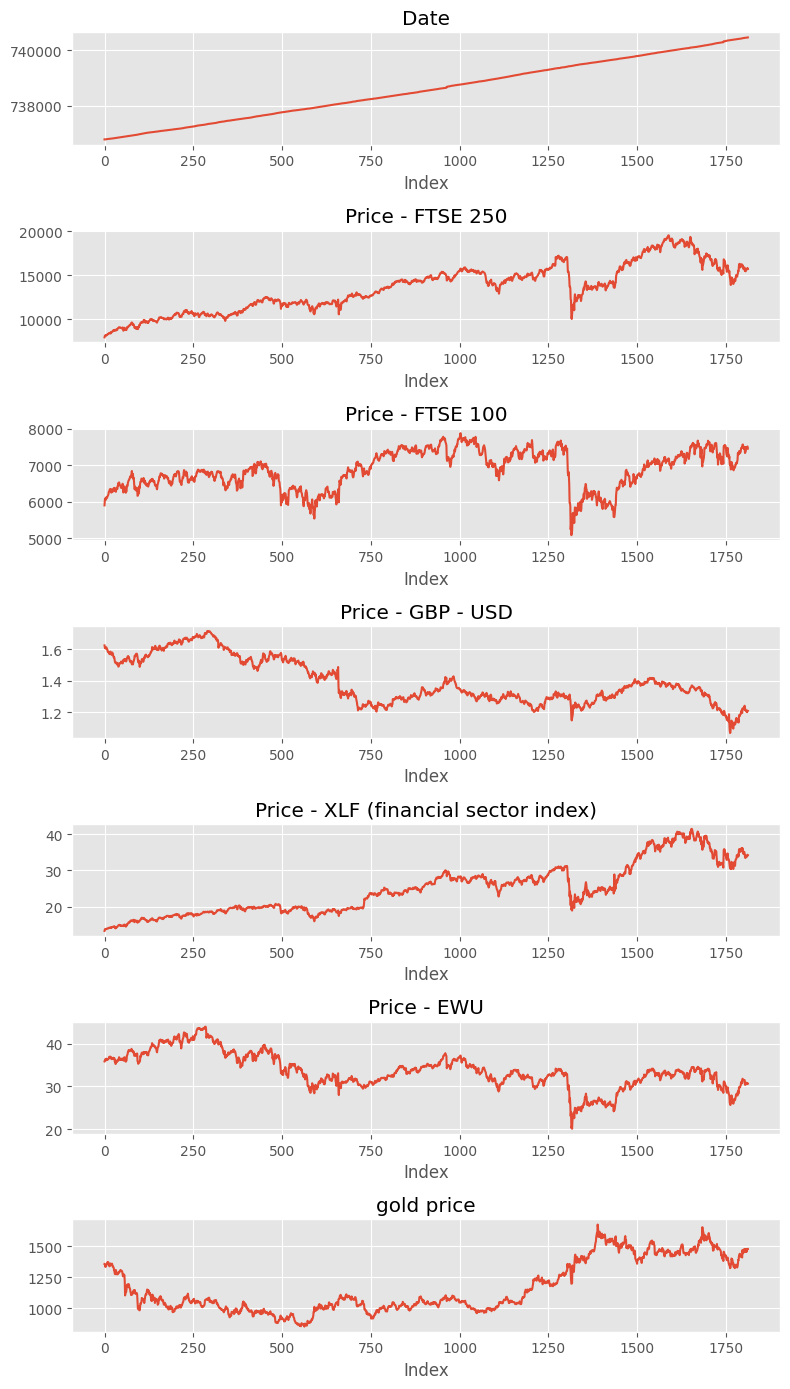

In [35]:
from scipy.stats import norm

dataset = X_trains[0]
num_feature = dataset.shape[1]
num_dp = dataset.shape[0]

fig, axes = plt.subplots(num_feature, 1, figsize=(8, 2*num_feature))
for i in range(num_feature):
    feature_data = dataset[:, i]
    axes[i].plot(range(num_dp), feature_data)
    axes[i].set_title(colnames[i])
    axes[i].set_xlabel('Index')
plt.tight_layout()
plt.show()

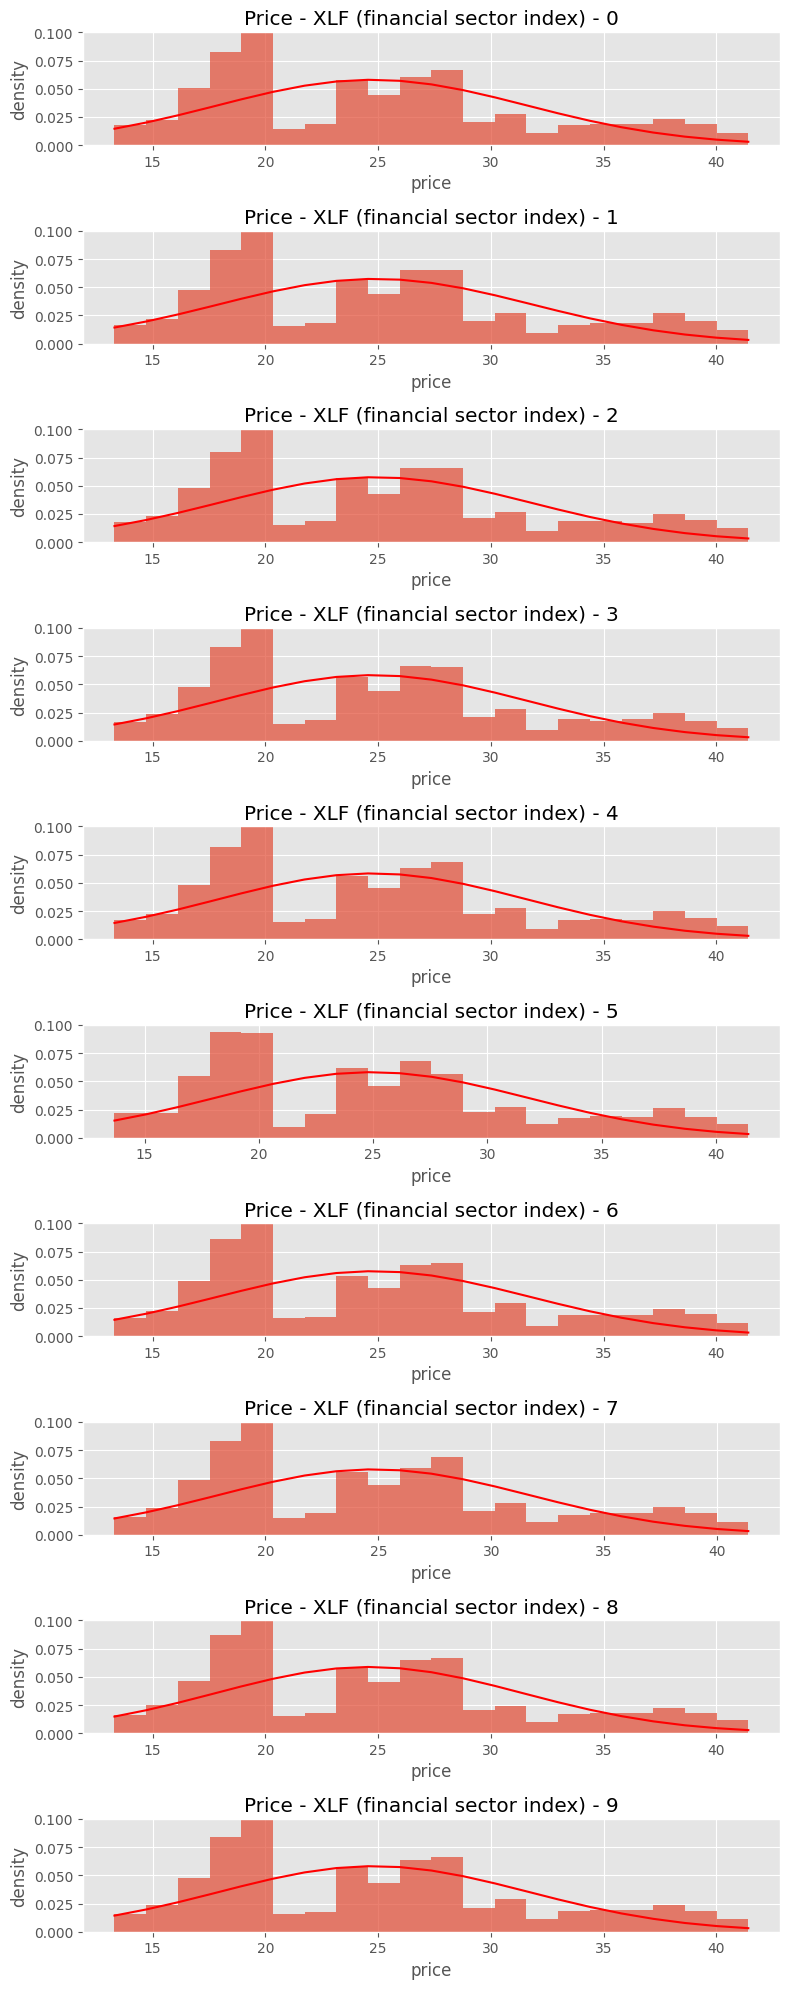

In [36]:
fig, axes = plt.subplots(10, 1, figsize=(8, 20))
for j, dataset in enumerate(X_trains):
    num_features = dataset.shape[1]
    num_dp = dataset.shape[0]
    for i in range(num_feature):
        if i==4:
            feature_data = dataset[:, i]
            n, bins, patches = axes[j].hist(feature_data, bins=20, density=True, alpha=0.7)
            kde = norm.pdf(bins, feature_data.mean(), feature_data.std())
            axes[j].plot(bins, kde, 'r-', label='KDE')
            axes[j].set_ylim(0, 0.1)
            axes[j].set_title(f'{colnames[i]} - {j}')
            axes[j].set_xlabel('price')
            axes[j].set_ylabel('density')
        else:
            continue
plt.tight_layout()
plt.show()  